# #10 Create a simple cantilever line beam model
<i>Creates and solves a steel beam cantilver model by creating basic mesh, geometric, material, support and loading attributes.</i>
*** 


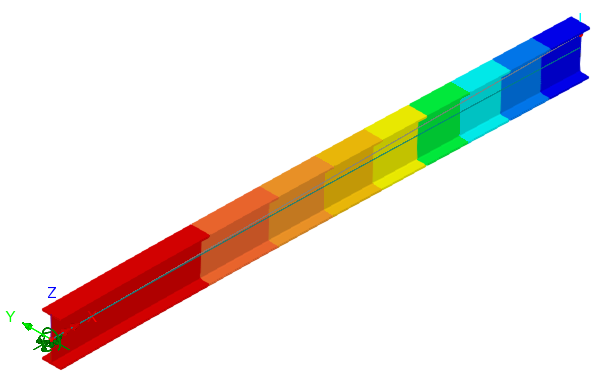

Geometry definition:

In [ ]:
# Input Params
length = 5.0 #m		     Length of beam
point_load = 10.0  #kN   Concentrated load on cantilever tip

Connect to LUSAS Modeller

In [ ]:
import sys; sys.path.append('../') # Reference modules in parent directory
from shared.LPI_21_1 import *
lusas = get_lusas_modeller()
if lusas.existsDatabase() and lusas.db().isModified():
    raise Exception("This script will create a new model. Please save or close the current model and try again")

Create new model (project) and set the model units: 

In [ ]:
# Create a new model
lusas.newProject("Structural", "Cantilever Line Beam.mdl")
# Get a reference to the model database
db = lusas.getDatabase()
# Set the analysis category & vertical axis
db.setAnalysisCategory("3D")
db.setVerticalDir("Z")
# Set the unit system
db.setModelUnits("kN,m,t,s,C")

Create the beam line

In [ ]:
''' Create a line'''
# Get the geometry data object
geomData = lusas.geometryData()
# Set the defaults
geomData.setAllDefaults()
# Set the coordinates of the first point
geomData.addCoords(0, 0, 0)
# Set the coordinates of the second point
geomData.addCoords(length, 0, 0)
# Create the line object from the geometry data
objs = db.createLine(geomData) # Modeller returns an object set containing all the lines created, in this case we only have 1.
# Get the lines
lines = objs.getObjects("Lines")
# Get the single line from the returned array
beamLine = lines[0]

Create attributes:
- an 1m line mesh attibute,
- a geometric Universal Beam 406x178x74kg attibute (section from the library),
- a steel material attribute,
- a fixed support attribute,
- a point load attribute

In [ ]:
''' Create a mesh attribute'''
meshAttr = db.createMeshLine("Beam Mesh")
# Set the element type and size of elements BMI21 = 2Node thick beam elements, 1 = 1m length
meshAttr.setSize("BMI21", 1)

In [ ]:
''' Create a geometric attribute'''
geomAttr = db.createGeometricLine("Beam Geometry")
# Set the element type
geomAttr.setValue("elementType", "3D Thick Beam")
# Set the beam section properties for the section library
geomAttr.setFromLibrary("UK Sections", "Universal Beams (BS4)", "406x178x74kg UB", 0, 0, 0)

In [ ]:
''' Create a material attribute'''
materialAttr = db.createIsotropicMaterial("Steel", 209_000_000, 0.3, 7.8)

In [ ]:
''' Create a support attribute (fixed) '''
fixedSupport = db.createSupportStructural("Fixed")
# set the freedoms F=Free, R=Restrained
fixedSupport.setStructural("R", "R", "R", "R", "R", "R", "F", "F", "F")

In [ ]:
''' Create a point load attribute '''
loadAttr = db.createLoadingConcentrated("Point load")
loadAttr.setConcentrated(0.0, 0.0, -point_load)

Now assign all the created attributes on the beam line:

In [ ]:
''' Assign the attributes to the geometry '''
# get the assignment object
assignment = lusas.assignment()
# set the defaults
assignment.setAllDefaults()

# Assign the mesh
meshAttr.assignTo(beamLine, assignment)
# Assign the geometry
geomAttr.assignTo(beamLine, assignment)
# Assign the material
materialAttr.assignTo(beamLine, assignment)
# Assign the loading
loadAttr.assignTo(beamLine.getEndPoint(), assignment)

''' Assign the supports to the points of the line '''
# Assign the fixed support to the first point
fixedSupport.assignTo(beamLine.getStartPoint(), assignment)


Notice that the mesh and section are not visualised unless the mesh is updated:

In [ ]:
# Mesh the model, ready for analysis
db.resetMesh()
db.updateMesh()
# Set the view
lusas.view().setIsometric()

Lastly, solve the analysis and show the displacement results:

In [ ]:
# Solve the analysis
db.getAnalysis("Analysis 1").solve(True)
db.openAllResults(True, True)

In [ ]:
# Display the deformed contours
lusas.view().insertContoursLayer()
lusas.view().contours().setResultsTransformNone()
lusas.view().contours().setResults("Displacement", "DZ")
lusas.view().contours().setShowDeformed(True)
lusas.view().insertAnnotationLayer()
lusas.view().attributes().setShowDeformed("Geometric", True)